In this notebook, we will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2023-08-21 18:53:05.380110: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-21 18:53:05.631561: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data preprocessing

In [21]:
PATH = 'fer2013'

train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

BATCH_SIZE = 32
IMG_SIZE =(160, 160)

In [22]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 28709 files belonging to 7 classes.


In [23]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 7178 files belonging to 7 classes.


Show the first nine images and labels from the training set:

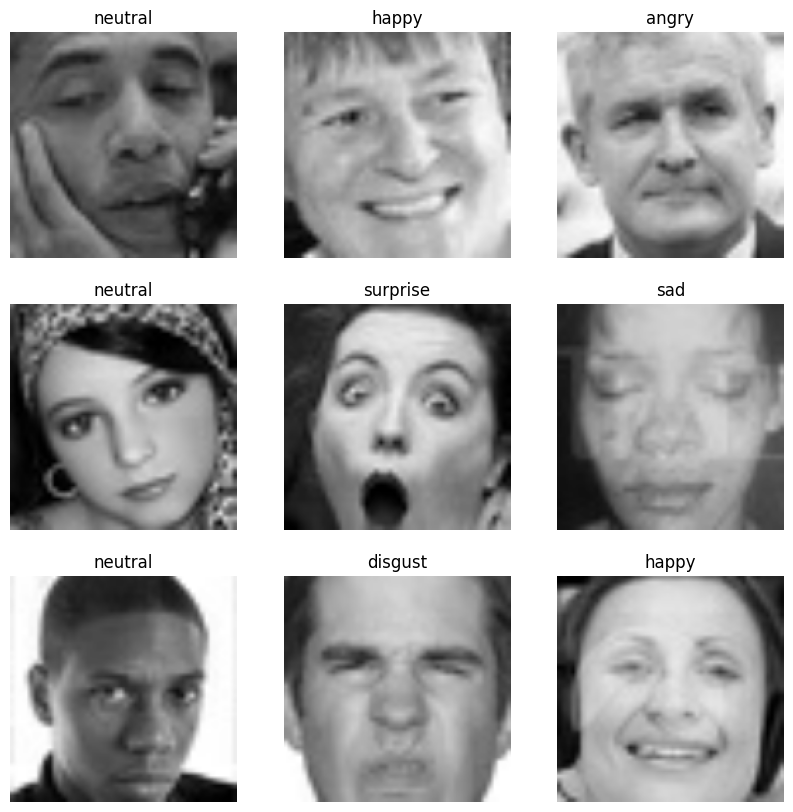

In [24]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a validation set, you will create one. To do so, determine how many batches of data are available in the training set using `tf.data.experimental.cardinality`, then move 20% of them to a validation set.

In [25]:
train_batches = tf.data.experimental.cardinality(train_dataset)
validation_dataset = train_dataset.take(train_batches // 5)
train_dataset = train_dataset.skip(train_batches // 5)

In [26]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of train batches: 719
Number of validation batches: 179


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [28]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

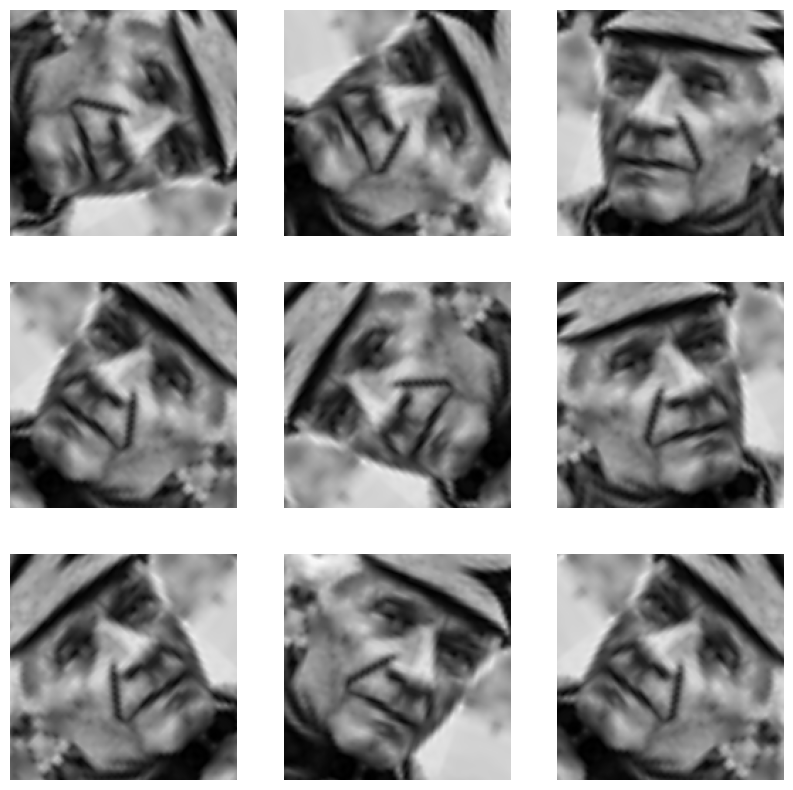

In [29]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [30]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [31]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 3s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [32]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-08-21 19:07:30.740835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


(32, 5, 5, 1280)


2023-08-21 19:07:33.867483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [33]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [34]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

 expanded_conv_depthwise_re  (None, 80, 80, 32)           0         ['expanded_conv_depthwise_BN[0


 lu (ReLU)                                                          ][0]']                        


 expanded_conv_project (Con  (None, 80, 80, 16)           512       ['expanded_conv_depthwise_relu


 v2D)                                                               [0][0]']                      


 expanded_conv_project_BN (  (None, 80, 80, 16)           64        ['expanded_conv_project[0][0]'


 BatchNormalization)                                                ]                             


 block_1_expand (Conv2D)     (None, 80, 80, 96)           1536      ['expanded_conv_project_BN[0][


                                                                    0]']                          


 block_1_expand_BN (BatchNo  (None, 80, 80, 96)           384       ['block_1_expand[0][0]']      


 rmalization)                                                                                     


 block_1_expand_relu (ReLU)  (None, 80, 80, 96)           0         ['block_1_expand_BN[0][0]']   


 block_1_pad (ZeroPadding2D  (None, 81, 81, 96)           0         ['block_1_expand_relu[0][0]'] 


 )                                                                                                


 block_1_depthwise (Depthwi  (None, 40, 40, 96)           864       ['block_1_pad[0][0]']         


 seConv2D)                                                                                        


 block_1_depthwise_BN (Batc  (None, 40, 40, 96)           384       ['block_1_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_1_depthwise_relu (Re  (None, 40, 40, 96)           0         ['block_1_depthwise_BN[0][0]']


 LU)                                                                                              


 block_1_project (Conv2D)    (None, 40, 40, 24)           2304      ['block_1_depthwise_relu[0][0]


                                                                    ']                            


 block_1_project_BN (BatchN  (None, 40, 40, 24)           96        ['block_1_project[0][0]']     


 ormalization)                                                                                    


 block_2_expand (Conv2D)     (None, 40, 40, 144)          3456      ['block_1_project_BN[0][0]']  


 block_2_expand_BN (BatchNo  (None, 40, 40, 144)          576       ['block_2_expand[0][0]']      


 rmalization)                                                                                     


 block_2_expand_relu (ReLU)  (None, 40, 40, 144)          0         ['block_2_expand_BN[0][0]']   


 block_2_depthwise (Depthwi  (None, 40, 40, 144)          1296      ['block_2_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_2_depthwise_BN (Batc  (None, 40, 40, 144)          576       ['block_2_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_2_depthwise_relu (Re  (None, 40, 40, 144)          0         ['block_2_depthwise_BN[0][0]']


 LU)                                                                                              


 block_2_project (Conv2D)    (None, 40, 40, 24)           3456      ['block_2_depthwise_relu[0][0]


                                                                    ']                            


 block_2_project_BN (BatchN  (None, 40, 40, 24)           96        ['block_2_project[0][0]']     


 ormalization)                                                                                    


 block_2_add (Add)           (None, 40, 40, 24)           0         ['block_1_project_BN[0][0]',  


                                                                     'block_2_project_BN[0][0]']  


 block_3_expand (Conv2D)     (None, 40, 40, 144)          3456      ['block_2_add[0][0]']         


 block_3_expand_BN (BatchNo  (None, 40, 40, 144)          576       ['block_3_expand[0][0]']      


 rmalization)                                                                                     


 block_3_expand_relu (ReLU)  (None, 40, 40, 144)          0         ['block_3_expand_BN[0][0]']   


 block_3_pad (ZeroPadding2D  (None, 41, 41, 144)          0         ['block_3_expand_relu[0][0]'] 


 )                                                                                                


 block_3_depthwise (Depthwi  (None, 20, 20, 144)          1296      ['block_3_pad[0][0]']         


 seConv2D)                                                                                        


 block_3_depthwise_BN (Batc  (None, 20, 20, 144)          576       ['block_3_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_3_depthwise_relu (Re  (None, 20, 20, 144)          0         ['block_3_depthwise_BN[0][0]']


 LU)                                                                                              


 block_3_project (Conv2D)    (None, 20, 20, 32)           4608      ['block_3_depthwise_relu[0][0]


                                                                    ']                            


 block_3_project_BN (BatchN  (None, 20, 20, 32)           128       ['block_3_project[0][0]']     


 ormalization)                                                                                    


 block_4_expand (Conv2D)     (None, 20, 20, 192)          6144      ['block_3_project_BN[0][0]']  


 block_4_expand_BN (BatchNo  (None, 20, 20, 192)          768       ['block_4_expand[0][0]']      


 rmalization)                                                                                     


 block_4_expand_relu (ReLU)  (None, 20, 20, 192)          0         ['block_4_expand_BN[0][0]']   


 block_4_depthwise (Depthwi  (None, 20, 20, 192)          1728      ['block_4_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_4_depthwise_BN (Batc  (None, 20, 20, 192)          768       ['block_4_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_4_depthwise_relu (Re  (None, 20, 20, 192)          0         ['block_4_depthwise_BN[0][0]']


 LU)                                                                                              


 block_4_project (Conv2D)    (None, 20, 20, 32)           6144      ['block_4_depthwise_relu[0][0]


                                                                    ']                            


 block_4_project_BN (BatchN  (None, 20, 20, 32)           128       ['block_4_project[0][0]']     


 ormalization)                                                                                    


 block_4_add (Add)           (None, 20, 20, 32)           0         ['block_3_project_BN[0][0]',  


                                                                     'block_4_project_BN[0][0]']  


 block_5_expand (Conv2D)     (None, 20, 20, 192)          6144      ['block_4_add[0][0]']         


 block_5_expand_BN (BatchNo  (None, 20, 20, 192)          768       ['block_5_expand[0][0]']      


 rmalization)                                                                                     


 block_5_expand_relu (ReLU)  (None, 20, 20, 192)          0         ['block_5_expand_BN[0][0]']   


 block_5_depthwise (Depthwi  (None, 20, 20, 192)          1728      ['block_5_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_5_depthwise_BN (Batc  (None, 20, 20, 192)          768       ['block_5_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_5_depthwise_relu (Re  (None, 20, 20, 192)          0         ['block_5_depthwise_BN[0][0]']


 LU)                                                                                              


 block_5_project (Conv2D)    (None, 20, 20, 32)           6144      ['block_5_depthwise_relu[0][0]


                                                                    ']                            


 block_5_project_BN (BatchN  (None, 20, 20, 32)           128       ['block_5_project[0][0]']     


 ormalization)                                                                                    


 block_5_add (Add)           (None, 20, 20, 32)           0         ['block_4_add[0][0]',         


                                                                     'block_5_project_BN[0][0]']  


 block_6_expand (Conv2D)     (None, 20, 20, 192)          6144      ['block_5_add[0][0]']         


 block_6_expand_BN (BatchNo  (None, 20, 20, 192)          768       ['block_6_expand[0][0]']      


 rmalization)                                                                                     


 block_6_expand_relu (ReLU)  (None, 20, 20, 192)          0         ['block_6_expand_BN[0][0]']   


 block_6_pad (ZeroPadding2D  (None, 21, 21, 192)          0         ['block_6_expand_relu[0][0]'] 


 )                                                                                                


 block_6_depthwise (Depthwi  (None, 10, 10, 192)          1728      ['block_6_pad[0][0]']         


 seConv2D)                                                                                        


 block_6_depthwise_BN (Batc  (None, 10, 10, 192)          768       ['block_6_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_6_depthwise_relu (Re  (None, 10, 10, 192)          0         ['block_6_depthwise_BN[0][0]']


 LU)                                                                                              


 block_6_project (Conv2D)    (None, 10, 10, 64)           12288     ['block_6_depthwise_relu[0][0]


                                                                    ']                            


 block_6_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_6_project[0][0]']     


 ormalization)                                                                                    


 block_7_expand (Conv2D)     (None, 10, 10, 384)          24576     ['block_6_project_BN[0][0]']  


 block_7_expand_BN (BatchNo  (None, 10, 10, 384)          1536      ['block_7_expand[0][0]']      


 rmalization)                                                                                     


 block_7_expand_relu (ReLU)  (None, 10, 10, 384)          0         ['block_7_expand_BN[0][0]']   


 block_7_depthwise (Depthwi  (None, 10, 10, 384)          3456      ['block_7_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_7_depthwise_BN (Batc  (None, 10, 10, 384)          1536      ['block_7_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_7_depthwise_relu (Re  (None, 10, 10, 384)          0         ['block_7_depthwise_BN[0][0]']


 LU)                                                                                              


 block_7_project (Conv2D)    (None, 10, 10, 64)           24576     ['block_7_depthwise_relu[0][0]


                                                                    ']                            


 block_7_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_7_project[0][0]']     


 ormalization)                                                                                    


 block_7_add (Add)           (None, 10, 10, 64)           0         ['block_6_project_BN[0][0]',  


                                                                     'block_7_project_BN[0][0]']  


 block_8_expand (Conv2D)     (None, 10, 10, 384)          24576     ['block_7_add[0][0]']         


 block_8_expand_BN (BatchNo  (None, 10, 10, 384)          1536      ['block_8_expand[0][0]']      


 rmalization)                                                                                     


 block_8_expand_relu (ReLU)  (None, 10, 10, 384)          0         ['block_8_expand_BN[0][0]']   


 block_8_depthwise (Depthwi  (None, 10, 10, 384)          3456      ['block_8_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_8_depthwise_BN (Batc  (None, 10, 10, 384)          1536      ['block_8_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_8_depthwise_relu (Re  (None, 10, 10, 384)          0         ['block_8_depthwise_BN[0][0]']


 LU)                                                                                              


 block_8_project (Conv2D)    (None, 10, 10, 64)           24576     ['block_8_depthwise_relu[0][0]


                                                                    ']                            


 block_8_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_8_project[0][0]']     


 ormalization)                                                                                    


 block_8_add (Add)           (None, 10, 10, 64)           0         ['block_7_add[0][0]',         


                                                                     'block_8_project_BN[0][0]']  


 block_9_expand (Conv2D)     (None, 10, 10, 384)          24576     ['block_8_add[0][0]']         


 block_9_expand_BN (BatchNo  (None, 10, 10, 384)          1536      ['block_9_expand[0][0]']      


 rmalization)                                                                                     


 block_9_expand_relu (ReLU)  (None, 10, 10, 384)          0         ['block_9_expand_BN[0][0]']   


 block_9_depthwise (Depthwi  (None, 10, 10, 384)          3456      ['block_9_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_9_depthwise_BN (Batc  (None, 10, 10, 384)          1536      ['block_9_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_9_depthwise_relu (Re  (None, 10, 10, 384)          0         ['block_9_depthwise_BN[0][0]']


 LU)                                                                                              


 block_9_project (Conv2D)    (None, 10, 10, 64)           24576     ['block_9_depthwise_relu[0][0]


                                                                    ']                            


 block_9_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_9_project[0][0]']     


 ormalization)                                                                                    


 block_9_add (Add)           (None, 10, 10, 64)           0         ['block_8_add[0][0]',         


                                                                     'block_9_project_BN[0][0]']  


 block_10_expand (Conv2D)    (None, 10, 10, 384)          24576     ['block_9_add[0][0]']         


 block_10_expand_BN (BatchN  (None, 10, 10, 384)          1536      ['block_10_expand[0][0]']     


 ormalization)                                                                                    


 block_10_expand_relu (ReLU  (None, 10, 10, 384)          0         ['block_10_expand_BN[0][0]']  


 )                                                                                                


 block_10_depthwise (Depthw  (None, 10, 10, 384)          3456      ['block_10_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_10_depthwise_BN (Bat  (None, 10, 10, 384)          1536      ['block_10_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_10_depthwise_relu (R  (None, 10, 10, 384)          0         ['block_10_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_10_project (Conv2D)   (None, 10, 10, 96)           36864     ['block_10_depthwise_relu[0][0


                                                                    ]']                           


 block_10_project_BN (Batch  (None, 10, 10, 96)           384       ['block_10_project[0][0]']    


 Normalization)                                                                                   


 block_11_expand (Conv2D)    (None, 10, 10, 576)          55296     ['block_10_project_BN[0][0]'] 


 block_11_expand_BN (BatchN  (None, 10, 10, 576)          2304      ['block_11_expand[0][0]']     


 ormalization)                                                                                    


 block_11_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_11_expand_BN[0][0]']  


 )                                                                                                


 block_11_depthwise (Depthw  (None, 10, 10, 576)          5184      ['block_11_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_11_depthwise_BN (Bat  (None, 10, 10, 576)          2304      ['block_11_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_11_depthwise_relu (R  (None, 10, 10, 576)          0         ['block_11_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_11_project (Conv2D)   (None, 10, 10, 96)           55296     ['block_11_depthwise_relu[0][0


                                                                    ]']                           


 block_11_project_BN (Batch  (None, 10, 10, 96)           384       ['block_11_project[0][0]']    


 Normalization)                                                                                   


 block_11_add (Add)          (None, 10, 10, 96)           0         ['block_10_project_BN[0][0]', 


                                                                     'block_11_project_BN[0][0]'] 


 block_12_expand (Conv2D)    (None, 10, 10, 576)          55296     ['block_11_add[0][0]']        


 block_12_expand_BN (BatchN  (None, 10, 10, 576)          2304      ['block_12_expand[0][0]']     


 ormalization)                                                                                    


 block_12_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_12_expand_BN[0][0]']  


 )                                                                                                


 block_12_depthwise (Depthw  (None, 10, 10, 576)          5184      ['block_12_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_12_depthwise_BN (Bat  (None, 10, 10, 576)          2304      ['block_12_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_12_depthwise_relu (R  (None, 10, 10, 576)          0         ['block_12_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_12_project (Conv2D)   (None, 10, 10, 96)           55296     ['block_12_depthwise_relu[0][0


                                                                    ]']                           


 block_12_project_BN (Batch  (None, 10, 10, 96)           384       ['block_12_project[0][0]']    


 Normalization)                                                                                   


 block_12_add (Add)          (None, 10, 10, 96)           0         ['block_11_add[0][0]',        


                                                                     'block_12_project_BN[0][0]'] 


 block_13_expand (Conv2D)    (None, 10, 10, 576)          55296     ['block_12_add[0][0]']        


 block_13_expand_BN (BatchN  (None, 10, 10, 576)          2304      ['block_13_expand[0][0]']     


 ormalization)                                                                                    


 block_13_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_13_expand_BN[0][0]']  


 )                                                                                                


 block_13_pad (ZeroPadding2  (None, 11, 11, 576)          0         ['block_13_expand_relu[0][0]']


 D)                                                                                               


 block_13_depthwise (Depthw  (None, 5, 5, 576)            5184      ['block_13_pad[0][0]']        


 iseConv2D)                                                                                       


 block_13_depthwise_BN (Bat  (None, 5, 5, 576)            2304      ['block_13_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_13_depthwise_relu (R  (None, 5, 5, 576)            0         ['block_13_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_13_project (Conv2D)   (None, 5, 5, 160)            92160     ['block_13_depthwise_relu[0][0


                                                                    ]']                           


 block_13_project_BN (Batch  (None, 5, 5, 160)            640       ['block_13_project[0][0]']    


 Normalization)                                                                                   


 block_14_expand (Conv2D)    (None, 5, 5, 960)            153600    ['block_13_project_BN[0][0]'] 


 block_14_expand_BN (BatchN  (None, 5, 5, 960)            3840      ['block_14_expand[0][0]']     


 ormalization)                                                                                    


 block_14_expand_relu (ReLU  (None, 5, 5, 960)            0         ['block_14_expand_BN[0][0]']  


 )                                                                                                


 block_14_depthwise (Depthw  (None, 5, 5, 960)            8640      ['block_14_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_14_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_14_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_14_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_14_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_14_project (Conv2D)   (None, 5, 5, 160)            153600    ['block_14_depthwise_relu[0][0


                                                                    ]']                           


 block_14_project_BN (Batch  (None, 5, 5, 160)            640       ['block_14_project[0][0]']    


 Normalization)                                                                                   


 block_14_add (Add)          (None, 5, 5, 160)            0         ['block_13_project_BN[0][0]', 


                                                                     'block_14_project_BN[0][0]'] 


 block_15_expand (Conv2D)    (None, 5, 5, 960)            153600    ['block_14_add[0][0]']        


 block_15_expand_BN (BatchN  (None, 5, 5, 960)            3840      ['block_15_expand[0][0]']     


 ormalization)                                                                                    


 block_15_expand_relu (ReLU  (None, 5, 5, 960)            0         ['block_15_expand_BN[0][0]']  


 )                                                                                                


 block_15_depthwise (Depthw  (None, 5, 5, 960)            8640      ['block_15_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_15_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_15_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_15_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_15_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_15_project (Conv2D)   (None, 5, 5, 160)            153600    ['block_15_depthwise_relu[0][0


                                                                    ]']                           


 block_15_project_BN (Batch  (None, 5, 5, 160)            640       ['block_15_project[0][0]']    


 Normalization)                                                                                   


 block_15_add (Add)          (None, 5, 5, 160)            0         ['block_14_add[0][0]',        


                                                                     'block_15_project_BN[0][0]'] 


 block_16_expand (Conv2D)    (None, 5, 5, 960)            153600    ['block_15_add[0][0]']        


 block_16_expand_BN (BatchN  (None, 5, 5, 960)            3840      ['block_16_expand[0][0]']     


 ormalization)                                                                                    


 block_16_expand_relu (ReLU  (None, 5, 5, 960)            0         ['block_16_expand_BN[0][0]']  


 )                                                                                                


 block_16_depthwise (Depthw  (None, 5, 5, 960)            8640      ['block_16_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_16_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_16_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_16_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_16_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_16_project (Conv2D)   (None, 5, 5, 320)            307200    ['block_16_depthwise_relu[0][0


                                                                    ]']                           


 block_16_project_BN (Batch  (None, 5, 5, 320)            1280      ['block_16_project[0][0]']    


 Normalization)                                                                                   


 Conv_1 (Conv2D)             (None, 5, 5, 1280)           409600    ['block_16_project_BN[0][0]'] 


 Conv_1_bn (BatchNormalizat  (None, 5, 5, 1280)           5120      ['Conv_1[0][0]']              


 ion)                                                                                             


 out_relu (ReLU)             (None, 5, 5, 1280)           0         ['Conv_1_bn[0][0]']           


Total params: 2257984 (8.61 MB)


Trainable params: 0 (0.00 Byte)


Non-trainable params: 2257984 (8.61 MB)


__________________________________________________________________________________________________


### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [36]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a 7 prediction per image.

In [37]:
prediction_layer = tf.keras.layers.Dense(7)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 7)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [38]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [39]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

 GlobalAveragePooling2D)                                         


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 1)                 1281      


Total params: 2259265 (8.62 MB)


Trainable params: 1281 (5.00 KB)


Non-trainable params: 2257984 (8.61 MB)


_________________________________________________________________


The 8+ million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [40]:
len(model.trainable_variables)

2

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [42]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [46]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

179/179 [==============================] - 8s 41ms/step - loss: 1.5855 - accuracy: 0.3883


In [47]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.59
initial accuracy: 0.39


In [48]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
719/719 [==============================] - 45s 53ms/step - loss: 1.6542 - accuracy: 0.3618 - val_loss: 1.5533 - val_accuracy: 0.4040
Epoch 2/10
719/719 [==============================] - 45s 53ms/step - loss: 1.6186 - accuracy: 0.3754 - val_loss: 1.5313 - val_accuracy: 0.4152
Epoch 3/10
719/719 [==============================] - 45s 52ms/step - loss: 1.5917 - accuracy: 0.3853 - val_loss: 1.5145 - val_accuracy: 0.4218
Epoch 4/10
719/719 [==============================] - 45s 53ms/step - loss: 1.5747 - accuracy: 0.3925 - val_loss: 1.5046 - val_accuracy: 0.4305
Epoch 5/10
719/719 [==============================] - 45s 53ms/step - loss: 1.5523 - accuracy: 0.4032 - val_loss: 1.4952 - val_accuracy: 0.4275
Epoch 6/10
719/719 [==============================] - 45s 53ms/step - loss: 1.5499 - accuracy: 0.4046 - val_loss: 1.4810 - val_accuracy: 0.4340
Epoch 7/10
719/719 [==============================] - 45s 53ms/step - loss: 1.5347 - accuracy: 0.4087 - val_loss: 1.4737 - val_accuracy:

27/63 [===========>..................] - ETA: 1s - loss: 0.8200 - accuracy: 0.4734

29/63 [============>.................] - ETA: 0s - loss: 0.8118 - accuracy: 0.4828

31/63 [=============>................] - ETA: 0s - loss: 0.8096 - accuracy: 0.4819

33/63 [==============>...............] - ETA: 0s - loss: 0.8082 - accuracy: 0.4839

35/63 [===============>..............] - ETA: 0s - loss: 0.8091 - accuracy: 0.4893

37/63 [================>.............] - ETA: 0s - loss: 0.8111 - accuracy: 0.4907

39/63 [=================>............] - ETA: 0s - loss: 0.8070 - accuracy: 0.4960

41/63 [==================>...........] - ETA: 0s - loss: 0.8008 - accuracy: 0.5008

43/63 [===================>..........] - ETA: 0s - loss: 0.7927 - accuracy: 0.5073

45/63 [====================>.........] - ETA: 0s - loss: 0.7870 - accuracy: 0.5097

47/63 [=====================>........] - ETA: 0s - loss: 0.7852 - accuracy: 0.5093

49/63 [======================>.......] - ETA: 0s - loss: 0.7783 - accuracy: 0.5147

51/63 [=======================>......] - ETA: 0s - loss: 0.7740 - accuracy: 0.5202

53/63 [========================>.....] - ETA: 0s - loss: 0.7694 - accuracy: 0.5224

55/63 [=========================>....] - ETA: 0s - loss: 0.7644 - accuracy: 0.5284

57/63 [==========================>...] - ETA: 0s - loss: 0.7630 - accuracy: 0.5280

59/63 [===========================>..] - ETA: 0s - loss: 0.7628 - accuracy: 0.5297

62/63 [============================>.] - ETA: 0s - loss: 0.7565 - accuracy: 0.5328

63/63 [==============================] - ETA: 0s - loss: 0.7561 - accuracy: 0.5330

63/63 [==============================] - 6s 43ms/step - loss: 0.7561 - accuracy: 0.5330 - val_loss: 0.6115 - val_accuracy: 0.6522


Epoch 2/10


 1/63 [..............................] - ETA: 4s - loss: 0.5589 - accuracy: 0.7500

 3/63 [>.............................] - ETA: 1s - loss: 0.6444 - accuracy: 0.6250

 5/63 [=>............................] - ETA: 1s - loss: 0.6470 - accuracy: 0.6375

 7/63 [==>...........................] - ETA: 1s - loss: 0.6497 - accuracy: 0.6339

 9/63 [===>..........................] - ETA: 1s - loss: 0.6571 - accuracy: 0.6389

11/63 [====>.........................] - ETA: 1s - loss: 0.6483 - accuracy: 0.6477

13/63 [=====>........................] - ETA: 1s - loss: 0.6480 - accuracy: 0.6514

15/63 [======>.......................] - ETA: 1s - loss: 0.6373 - accuracy: 0.6583

17/63 [=======>......................] - ETA: 1s - loss: 0.6211 - accuracy: 0.6710

19/63 [========>.....................] - ETA: 1s - loss: 0.6243 - accuracy: 0.6743

21/63 [=========>....................] - ETA: 1s - loss: 0.6154 - accuracy: 0.6801

23/63 [=========>....................] - ETA: 1s - loss: 0.6082 - accuracy: 0.6875

25/63 [==========>...................] - ETA: 0s - loss: 0.6052 - accuracy: 0.6900

27/63 [===========>..................] - ETA: 0s - loss: 0.6068 - accuracy: 0.6875

29/63 [============>.................] - ETA: 0s - loss: 0.6078 - accuracy: 0.6843

31/63 [=============>................] - ETA: 0s - loss: 0.6004 - accuracy: 0.6905

33/63 [==============>...............] - ETA: 0s - loss: 0.5972 - accuracy: 0.6941

35/63 [===============>..............] - ETA: 0s - loss: 0.5895 - accuracy: 0.6991

37/63 [================>.............] - ETA: 0s - loss: 0.5889 - accuracy: 0.7027

39/63 [=================>............] - ETA: 0s - loss: 0.5865 - accuracy: 0.7043

41/63 [==================>...........] - ETA: 0s - loss: 0.5829 - accuracy: 0.7088

43/63 [===================>..........] - ETA: 0s - loss: 0.5782 - accuracy: 0.7129

45/63 [====================>.........] - ETA: 0s - loss: 0.5744 - accuracy: 0.7153

47/63 [=====================>........] - ETA: 0s - loss: 0.5704 - accuracy: 0.7201

49/63 [======================>.......] - ETA: 0s - loss: 0.5650 - accuracy: 0.7239

51/63 [=======================>......] - ETA: 0s - loss: 0.5652 - accuracy: 0.7218

53/63 [========================>.....] - ETA: 0s - loss: 0.5621 - accuracy: 0.7223

55/63 [=========================>....] - ETA: 0s - loss: 0.5599 - accuracy: 0.7244

57/63 [==========================>...] - ETA: 0s - loss: 0.5605 - accuracy: 0.7226

60/63 [===========================>..] - ETA: 0s - loss: 0.5571 - accuracy: 0.7245

62/63 [============================>.] - ETA: 0s - loss: 0.5542 - accuracy: 0.7263

63/63 [==============================] - 2s 36ms/step - loss: 0.5535 - accuracy: 0.7270 - val_loss: 0.4378 - val_accuracy: 0.8527


Epoch 3/10


 1/63 [..............................] - ETA: 4s - loss: 0.4794 - accuracy: 0.7500

 3/63 [>.............................] - ETA: 1s - loss: 0.4970 - accuracy: 0.7500

 5/63 [=>............................] - ETA: 1s - loss: 0.4817 - accuracy: 0.7563

 7/63 [==>...........................] - ETA: 1s - loss: 0.4851 - accuracy: 0.7545

 9/63 [===>..........................] - ETA: 1s - loss: 0.4829 - accuracy: 0.7604

11/63 [====>.........................] - ETA: 1s - loss: 0.4792 - accuracy: 0.7727

13/63 [=====>........................] - ETA: 1s - loss: 0.4699 - accuracy: 0.7885

15/63 [======>.......................] - ETA: 1s - loss: 0.4841 - accuracy: 0.7771

17/63 [=======>......................] - ETA: 1s - loss: 0.4701 - accuracy: 0.7886

19/63 [========>.....................] - ETA: 1s - loss: 0.4640 - accuracy: 0.7878

21/63 [=========>....................] - ETA: 1s - loss: 0.4644 - accuracy: 0.7902

23/63 [=========>....................] - ETA: 1s - loss: 0.4582 - accuracy: 0.7962

25/63 [==========>...................] - ETA: 0s - loss: 0.4651 - accuracy: 0.7900

27/63 [===========>..................] - ETA: 0s - loss: 0.4622 - accuracy: 0.7917

29/63 [============>.................] - ETA: 0s - loss: 0.4610 - accuracy: 0.7942

31/63 [=============>................] - ETA: 0s - loss: 0.4616 - accuracy: 0.7994

33/63 [==============>...............] - ETA: 0s - loss: 0.4577 - accuracy: 0.8011

35/63 [===============>..............] - ETA: 0s - loss: 0.4563 - accuracy: 0.8018

37/63 [================>.............] - ETA: 0s - loss: 0.4568 - accuracy: 0.8015

39/63 [=================>............] - ETA: 0s - loss: 0.4530 - accuracy: 0.8037

41/63 [==================>...........] - ETA: 0s - loss: 0.4478 - accuracy: 0.8102

43/63 [===================>..........] - ETA: 0s - loss: 0.4480 - accuracy: 0.8081

45/63 [====================>.........] - ETA: 0s - loss: 0.4463 - accuracy: 0.8097

47/63 [=====================>........] - ETA: 0s - loss: 0.4491 - accuracy: 0.8078

49/63 [======================>.......] - ETA: 0s - loss: 0.4483 - accuracy: 0.8099

51/63 [=======================>......] - ETA: 0s - loss: 0.4460 - accuracy: 0.8119

53/63 [========================>.....] - ETA: 0s - loss: 0.4444 - accuracy: 0.8131

55/63 [=========================>....] - ETA: 0s - loss: 0.4441 - accuracy: 0.8125

58/63 [==========================>...] - ETA: 0s - loss: 0.4416 - accuracy: 0.8141

60/63 [===========================>..] - ETA: 0s - loss: 0.4399 - accuracy: 0.8156

63/63 [==============================] - ETA: 0s - loss: 0.4388 - accuracy: 0.8155

63/63 [==============================] - 2s 36ms/step - loss: 0.4388 - accuracy: 0.8155 - val_loss: 0.3403 - val_accuracy: 0.9084


Epoch 4/10


 1/63 [..............................] - ETA: 3s - loss: 0.3090 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 1s - loss: 0.4244 - accuracy: 0.8229

 5/63 [=>............................] - ETA: 1s - loss: 0.4093 - accuracy: 0.8438

 7/63 [==>...........................] - ETA: 1s - loss: 0.4209 - accuracy: 0.8393

 9/63 [===>..........................] - ETA: 1s - loss: 0.4096 - accuracy: 0.8438

11/63 [====>.........................] - ETA: 1s - loss: 0.4060 - accuracy: 0.8466

13/63 [=====>........................] - ETA: 1s - loss: 0.4077 - accuracy: 0.8558

15/63 [======>.......................] - ETA: 1s - loss: 0.4202 - accuracy: 0.8396

17/63 [=======>......................] - ETA: 1s - loss: 0.4112 - accuracy: 0.8474

19/63 [========>.....................] - ETA: 1s - loss: 0.4030 - accuracy: 0.8503

21/63 [=========>....................] - ETA: 1s - loss: 0.4044 - accuracy: 0.8467

23/63 [=========>....................] - ETA: 1s - loss: 0.4011 - accuracy: 0.8492

25/63 [==========>...................] - ETA: 0s - loss: 0.4026 - accuracy: 0.8500

27/63 [===========>..................] - ETA: 0s - loss: 0.3980 - accuracy: 0.8519

29/63 [============>.................] - ETA: 0s - loss: 0.3978 - accuracy: 0.8502

31/63 [=============>................] - ETA: 0s - loss: 0.3996 - accuracy: 0.8488

33/63 [==============>...............] - ETA: 0s - loss: 0.3955 - accuracy: 0.8504

35/63 [===============>..............] - ETA: 0s - loss: 0.3929 - accuracy: 0.8500

37/63 [================>.............] - ETA: 0s - loss: 0.3893 - accuracy: 0.8505

39/63 [=================>............] - ETA: 0s - loss: 0.3899 - accuracy: 0.8470

41/63 [==================>...........] - ETA: 0s - loss: 0.3877 - accuracy: 0.8460

43/63 [===================>..........] - ETA: 0s - loss: 0.3853 - accuracy: 0.8467

45/63 [====================>.........] - ETA: 0s - loss: 0.3834 - accuracy: 0.8472

47/63 [=====================>........] - ETA: 0s - loss: 0.3805 - accuracy: 0.8491

49/63 [======================>.......] - ETA: 0s - loss: 0.3791 - accuracy: 0.8501

51/63 [=======================>......] - ETA: 0s - loss: 0.3776 - accuracy: 0.8511

53/63 [========================>.....] - ETA: 0s - loss: 0.3770 - accuracy: 0.8514

55/63 [=========================>....] - ETA: 0s - loss: 0.3762 - accuracy: 0.8500

57/63 [==========================>...] - ETA: 0s - loss: 0.3746 - accuracy: 0.8503

60/63 [===========================>..] - ETA: 0s - loss: 0.3710 - accuracy: 0.8521

63/63 [==============================] - ETA: 0s - loss: 0.3688 - accuracy: 0.8520

63/63 [==============================] - 2s 36ms/step - loss: 0.3688 - accuracy: 0.8520 - val_loss: 0.2753 - val_accuracy: 0.9356


Epoch 5/10


 1/63 [..............................] - ETA: 3s - loss: 0.3506 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 1s - loss: 0.3222 - accuracy: 0.8854

 5/63 [=>............................] - ETA: 1s - loss: 0.3231 - accuracy: 0.8813

 7/63 [==>...........................] - ETA: 1s - loss: 0.3172 - accuracy: 0.8750

 9/63 [===>..........................] - ETA: 1s - loss: 0.3317 - accuracy: 0.8611

11/63 [====>.........................] - ETA: 1s - loss: 0.3351 - accuracy: 0.8636

13/63 [=====>........................] - ETA: 1s - loss: 0.3337 - accuracy: 0.8678

15/63 [======>.......................] - ETA: 1s - loss: 0.3387 - accuracy: 0.8604

17/63 [=======>......................] - ETA: 1s - loss: 0.3301 - accuracy: 0.8695

19/63 [========>.....................] - ETA: 1s - loss: 0.3316 - accuracy: 0.8668

21/63 [=========>....................] - ETA: 1s - loss: 0.3314 - accuracy: 0.8661

23/63 [=========>....................] - ETA: 1s - loss: 0.3319 - accuracy: 0.8696

25/63 [==========>...................] - ETA: 0s - loss: 0.3335 - accuracy: 0.8687

27/63 [===========>..................] - ETA: 0s - loss: 0.3349 - accuracy: 0.8692

29/63 [============>.................] - ETA: 0s - loss: 0.3331 - accuracy: 0.8696

31/63 [=============>................] - ETA: 0s - loss: 0.3327 - accuracy: 0.8700

33/63 [==============>...............] - ETA: 0s - loss: 0.3269 - accuracy: 0.8731

35/63 [===============>..............] - ETA: 0s - loss: 0.3243 - accuracy: 0.8741

37/63 [================>.............] - ETA: 0s - loss: 0.3267 - accuracy: 0.8733

39/63 [=================>............] - ETA: 0s - loss: 0.3217 - accuracy: 0.8766

41/63 [==================>...........] - ETA: 0s - loss: 0.3227 - accuracy: 0.8735

43/63 [===================>..........] - ETA: 0s - loss: 0.3220 - accuracy: 0.8735

45/63 [====================>.........] - ETA: 0s - loss: 0.3204 - accuracy: 0.8750

47/63 [=====================>........] - ETA: 0s - loss: 0.3189 - accuracy: 0.8743

49/63 [======================>.......] - ETA: 0s - loss: 0.3204 - accuracy: 0.8731

51/63 [=======================>......] - ETA: 0s - loss: 0.3181 - accuracy: 0.8738

53/63 [========================>.....] - ETA: 0s - loss: 0.3177 - accuracy: 0.8738

55/63 [=========================>....] - ETA: 0s - loss: 0.3179 - accuracy: 0.8744

57/63 [==========================>...] - ETA: 0s - loss: 0.3190 - accuracy: 0.8739

60/63 [===========================>..] - ETA: 0s - loss: 0.3165 - accuracy: 0.8771

63/63 [==============================] - ETA: 0s - loss: 0.3151 - accuracy: 0.8780

63/63 [==============================] - 2s 36ms/step - loss: 0.3151 - accuracy: 0.8780 - val_loss: 0.2325 - val_accuracy: 0.9431


Epoch 6/10


 1/63 [..............................] - ETA: 3s - loss: 0.4221 - accuracy: 0.8125

 3/63 [>.............................] - ETA: 1s - loss: 0.3069 - accuracy: 0.8646

 5/63 [=>............................] - ETA: 1s - loss: 0.3218 - accuracy: 0.8813

 7/63 [==>...........................] - ETA: 1s - loss: 0.3178 - accuracy: 0.8795

 9/63 [===>..........................] - ETA: 1s - loss: 0.2986 - accuracy: 0.8854

11/63 [====>.........................] - ETA: 1s - loss: 0.2900 - accuracy: 0.8920

13/63 [=====>........................] - ETA: 1s - loss: 0.3062 - accuracy: 0.8774

15/63 [======>.......................] - ETA: 1s - loss: 0.2985 - accuracy: 0.8896

17/63 [=======>......................] - ETA: 1s - loss: 0.2996 - accuracy: 0.8842

19/63 [========>.....................] - ETA: 1s - loss: 0.3043 - accuracy: 0.8816

21/63 [=========>....................] - ETA: 1s - loss: 0.3025 - accuracy: 0.8839

23/63 [=========>....................] - ETA: 1s - loss: 0.3023 - accuracy: 0.8804

25/63 [==========>...................] - ETA: 0s - loss: 0.3011 - accuracy: 0.8800

27/63 [===========>..................] - ETA: 0s - loss: 0.3011 - accuracy: 0.8819

29/63 [============>.................] - ETA: 0s - loss: 0.3049 - accuracy: 0.8804

31/63 [=============>................] - ETA: 0s - loss: 0.3095 - accuracy: 0.8750

33/63 [==============>...............] - ETA: 0s - loss: 0.3109 - accuracy: 0.8759

35/63 [===============>..............] - ETA: 0s - loss: 0.3082 - accuracy: 0.8777

37/63 [================>.............] - ETA: 0s - loss: 0.3030 - accuracy: 0.8801

39/63 [=================>............] - ETA: 0s - loss: 0.2991 - accuracy: 0.8830

41/63 [==================>...........] - ETA: 0s - loss: 0.2973 - accuracy: 0.8841

43/63 [===================>..........] - ETA: 0s - loss: 0.2991 - accuracy: 0.8815

45/63 [====================>.........] - ETA: 0s - loss: 0.3058 - accuracy: 0.8764

47/63 [=====================>........] - ETA: 0s - loss: 0.3066 - accuracy: 0.8763

49/63 [======================>.......] - ETA: 0s - loss: 0.3044 - accuracy: 0.8769

51/63 [=======================>......] - ETA: 0s - loss: 0.3024 - accuracy: 0.8787

53/63 [========================>.....] - ETA: 0s - loss: 0.2988 - accuracy: 0.8809

55/63 [=========================>....] - ETA: 0s - loss: 0.3010 - accuracy: 0.8801

57/63 [==========================>...] - ETA: 0s - loss: 0.2993 - accuracy: 0.8810

60/63 [===========================>..] - ETA: 0s - loss: 0.2999 - accuracy: 0.8802

62/63 [============================>.] - ETA: 0s - loss: 0.2977 - accuracy: 0.8805

63/63 [==============================] - 2s 36ms/step - loss: 0.2979 - accuracy: 0.8810 - val_loss: 0.1995 - val_accuracy: 0.9542


Epoch 7/10


 1/63 [..............................] - ETA: 4s - loss: 0.2852 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 1s - loss: 0.2979 - accuracy: 0.8542

 5/63 [=>............................] - ETA: 1s - loss: 0.2674 - accuracy: 0.8875

 7/63 [==>...........................] - ETA: 1s - loss: 0.2787 - accuracy: 0.8884

 9/63 [===>..........................] - ETA: 1s - loss: 0.3153 - accuracy: 0.8681

11/63 [====>.........................] - ETA: 1s - loss: 0.2976 - accuracy: 0.8778

13/63 [=====>........................] - ETA: 1s - loss: 0.2896 - accuracy: 0.8894

15/63 [======>.......................] - ETA: 1s - loss: 0.2803 - accuracy: 0.8958

17/63 [=======>......................] - ETA: 1s - loss: 0.2825 - accuracy: 0.8934

19/63 [========>.....................] - ETA: 1s - loss: 0.2864 - accuracy: 0.8947

21/63 [=========>....................] - ETA: 1s - loss: 0.2794 - accuracy: 0.8973

23/63 [=========>....................] - ETA: 1s - loss: 0.2768 - accuracy: 0.8954

25/63 [==========>...................] - ETA: 0s - loss: 0.2802 - accuracy: 0.8938

27/63 [===========>..................] - ETA: 0s - loss: 0.2805 - accuracy: 0.8912

29/63 [============>.................] - ETA: 0s - loss: 0.2801 - accuracy: 0.8922

31/63 [=============>................] - ETA: 0s - loss: 0.2773 - accuracy: 0.8942

33/63 [==============>...............] - ETA: 0s - loss: 0.2790 - accuracy: 0.8920

35/63 [===============>..............] - ETA: 0s - loss: 0.2794 - accuracy: 0.8946

37/63 [================>.............] - ETA: 0s - loss: 0.2740 - accuracy: 0.8978

39/63 [=================>............] - ETA: 0s - loss: 0.2749 - accuracy: 0.8982

41/63 [==================>...........] - ETA: 0s - loss: 0.2744 - accuracy: 0.8979

43/63 [===================>..........] - ETA: 0s - loss: 0.2758 - accuracy: 0.8975

45/63 [====================>.........] - ETA: 0s - loss: 0.2742 - accuracy: 0.8979

47/63 [=====================>........] - ETA: 0s - loss: 0.2708 - accuracy: 0.8996

49/63 [======================>.......] - ETA: 0s - loss: 0.2706 - accuracy: 0.9011

51/63 [=======================>......] - ETA: 0s - loss: 0.2712 - accuracy: 0.9013

53/63 [========================>.....] - ETA: 0s - loss: 0.2687 - accuracy: 0.9027

55/63 [=========================>....] - ETA: 0s - loss: 0.2687 - accuracy: 0.9023

57/63 [==========================>...] - ETA: 0s - loss: 0.2690 - accuracy: 0.9019

59/63 [===========================>..] - ETA: 0s - loss: 0.2686 - accuracy: 0.9025

61/63 [============================>.] - ETA: 0s - loss: 0.2679 - accuracy: 0.9032

63/63 [==============================] - 2s 36ms/step - loss: 0.2662 - accuracy: 0.9045 - val_loss: 0.1728 - val_accuracy: 0.9604


Epoch 8/10


 1/63 [..............................] - ETA: 3s - loss: 0.3148 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 1s - loss: 0.2548 - accuracy: 0.9062

 5/63 [=>............................] - ETA: 1s - loss: 0.2562 - accuracy: 0.9000

 7/63 [==>...........................] - ETA: 1s - loss: 0.2664 - accuracy: 0.8929

 9/63 [===>..........................] - ETA: 1s - loss: 0.2655 - accuracy: 0.8889

11/63 [====>.........................] - ETA: 1s - loss: 0.2572 - accuracy: 0.8920

13/63 [=====>........................] - ETA: 1s - loss: 0.2515 - accuracy: 0.8942

15/63 [======>.......................] - ETA: 1s - loss: 0.2444 - accuracy: 0.9000

17/63 [=======>......................] - ETA: 1s - loss: 0.2561 - accuracy: 0.8897

19/63 [========>.....................] - ETA: 1s - loss: 0.2510 - accuracy: 0.8964

21/63 [=========>....................] - ETA: 1s - loss: 0.2488 - accuracy: 0.8973

23/63 [=========>....................] - ETA: 1s - loss: 0.2485 - accuracy: 0.8967

25/63 [==========>...................] - ETA: 0s - loss: 0.2445 - accuracy: 0.9000

27/63 [===========>..................] - ETA: 0s - loss: 0.2401 - accuracy: 0.9051

29/63 [============>.................] - ETA: 0s - loss: 0.2381 - accuracy: 0.9095

31/63 [=============>................] - ETA: 0s - loss: 0.2400 - accuracy: 0.9093

33/63 [==============>...............] - ETA: 0s - loss: 0.2491 - accuracy: 0.9015

35/63 [===============>..............] - ETA: 0s - loss: 0.2501 - accuracy: 0.9036

37/63 [================>.............] - ETA: 0s - loss: 0.2512 - accuracy: 0.9029

39/63 [=================>............] - ETA: 0s - loss: 0.2545 - accuracy: 0.9006

41/63 [==================>...........] - ETA: 0s - loss: 0.2538 - accuracy: 0.9017

43/63 [===================>..........] - ETA: 0s - loss: 0.2508 - accuracy: 0.9048

45/63 [====================>.........] - ETA: 0s - loss: 0.2527 - accuracy: 0.9035

47/63 [=====================>........] - ETA: 0s - loss: 0.2506 - accuracy: 0.9056

49/63 [======================>.......] - ETA: 0s - loss: 0.2510 - accuracy: 0.9056

51/63 [=======================>......] - ETA: 0s - loss: 0.2526 - accuracy: 0.9044

53/63 [========================>.....] - ETA: 0s - loss: 0.2506 - accuracy: 0.9062

55/63 [=========================>....] - ETA: 0s - loss: 0.2489 - accuracy: 0.9074

57/63 [==========================>...] - ETA: 0s - loss: 0.2473 - accuracy: 0.9084

59/63 [===========================>..] - ETA: 0s - loss: 0.2476 - accuracy: 0.9084

61/63 [============================>.] - ETA: 0s - loss: 0.2472 - accuracy: 0.9088

63/63 [==============================] - 2s 36ms/step - loss: 0.2486 - accuracy: 0.9080 - val_loss: 0.1618 - val_accuracy: 0.9629


Epoch 9/10


 1/63 [..............................] - ETA: 3s - loss: 0.2594 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 1s - loss: 0.2969 - accuracy: 0.9271

 5/63 [=>............................] - ETA: 1s - loss: 0.2514 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 1s - loss: 0.2576 - accuracy: 0.9241

 9/63 [===>..........................] - ETA: 1s - loss: 0.2567 - accuracy: 0.9236

11/63 [====>.........................] - ETA: 1s - loss: 0.2579 - accuracy: 0.9205

13/63 [=====>........................] - ETA: 1s - loss: 0.2519 - accuracy: 0.9183

15/63 [======>.......................] - ETA: 1s - loss: 0.2518 - accuracy: 0.9167

17/63 [=======>......................] - ETA: 1s - loss: 0.2468 - accuracy: 0.9173

19/63 [========>.....................] - ETA: 1s - loss: 0.2515 - accuracy: 0.9161

21/63 [=========>....................] - ETA: 1s - loss: 0.2449 - accuracy: 0.9182

23/63 [=========>....................] - ETA: 1s - loss: 0.2388 - accuracy: 0.9226

25/63 [==========>...................] - ETA: 0s - loss: 0.2416 - accuracy: 0.9187

27/63 [===========>..................] - ETA: 0s - loss: 0.2336 - accuracy: 0.9225

29/63 [============>.................] - ETA: 0s - loss: 0.2314 - accuracy: 0.9224

31/63 [=============>................] - ETA: 0s - loss: 0.2281 - accuracy: 0.9234

33/63 [==============>...............] - ETA: 0s - loss: 0.2276 - accuracy: 0.9242

35/63 [===============>..............] - ETA: 0s - loss: 0.2359 - accuracy: 0.9187

37/63 [================>.............] - ETA: 0s - loss: 0.2371 - accuracy: 0.9181

39/63 [=================>............] - ETA: 0s - loss: 0.2350 - accuracy: 0.9191

41/63 [==================>...........] - ETA: 0s - loss: 0.2361 - accuracy: 0.9177

43/63 [===================>..........] - ETA: 0s - loss: 0.2352 - accuracy: 0.9172

45/63 [====================>.........] - ETA: 0s - loss: 0.2354 - accuracy: 0.9167

47/63 [=====================>........] - ETA: 0s - loss: 0.2349 - accuracy: 0.9169

49/63 [======================>.......] - ETA: 0s - loss: 0.2319 - accuracy: 0.9190

51/63 [=======================>......] - ETA: 0s - loss: 0.2295 - accuracy: 0.9203

53/63 [========================>.....] - ETA: 0s - loss: 0.2295 - accuracy: 0.9222

55/63 [=========================>....] - ETA: 0s - loss: 0.2315 - accuracy: 0.9205

57/63 [==========================>...] - ETA: 0s - loss: 0.2309 - accuracy: 0.9221

59/63 [===========================>..] - ETA: 0s - loss: 0.2284 - accuracy: 0.9237

62/63 [============================>.] - ETA: 0s - loss: 0.2272 - accuracy: 0.9244

63/63 [==============================] - 2s 36ms/step - loss: 0.2261 - accuracy: 0.9250 - val_loss: 0.1500 - val_accuracy: 0.9641


Epoch 10/10


 1/63 [..............................] - ETA: 3s - loss: 0.3318 - accuracy: 0.8438

 3/63 [>.............................] - ETA: 1s - loss: 0.2588 - accuracy: 0.8646

 5/63 [=>............................] - ETA: 1s - loss: 0.2305 - accuracy: 0.8813

 7/63 [==>...........................] - ETA: 1s - loss: 0.2117 - accuracy: 0.9062

 9/63 [===>..........................] - ETA: 1s - loss: 0.2299 - accuracy: 0.9062

11/63 [====>.........................] - ETA: 1s - loss: 0.2291 - accuracy: 0.9062

13/63 [=====>........................] - ETA: 1s - loss: 0.2364 - accuracy: 0.9038

15/63 [======>.......................] - ETA: 1s - loss: 0.2382 - accuracy: 0.9062

17/63 [=======>......................] - ETA: 1s - loss: 0.2283 - accuracy: 0.9118

19/63 [========>.....................] - ETA: 1s - loss: 0.2247 - accuracy: 0.9128

21/63 [=========>....................] - ETA: 1s - loss: 0.2197 - accuracy: 0.9137

23/63 [=========>....................] - ETA: 1s - loss: 0.2221 - accuracy: 0.9130

25/63 [==========>...................] - ETA: 0s - loss: 0.2165 - accuracy: 0.9162

27/63 [===========>..................] - ETA: 0s - loss: 0.2211 - accuracy: 0.9155

29/63 [============>.................] - ETA: 0s - loss: 0.2201 - accuracy: 0.9159

31/63 [=============>................] - ETA: 0s - loss: 0.2161 - accuracy: 0.9183

33/63 [==============>...............] - ETA: 0s - loss: 0.2162 - accuracy: 0.9186

35/63 [===============>..............] - ETA: 0s - loss: 0.2189 - accuracy: 0.9170

37/63 [================>.............] - ETA: 0s - loss: 0.2176 - accuracy: 0.9189

39/63 [=================>............] - ETA: 0s - loss: 0.2140 - accuracy: 0.9199

41/63 [==================>...........] - ETA: 0s - loss: 0.2174 - accuracy: 0.9200

43/63 [===================>..........] - ETA: 0s - loss: 0.2144 - accuracy: 0.9215

45/63 [====================>.........] - ETA: 0s - loss: 0.2139 - accuracy: 0.9222

47/63 [=====================>........] - ETA: 0s - loss: 0.2124 - accuracy: 0.9229

49/63 [======================>.......] - ETA: 0s - loss: 0.2143 - accuracy: 0.9190

51/63 [=======================>......] - ETA: 0s - loss: 0.2155 - accuracy: 0.9173

53/63 [========================>.....] - ETA: 0s - loss: 0.2126 - accuracy: 0.9192

55/63 [=========================>....] - ETA: 0s - loss: 0.2158 - accuracy: 0.9165

57/63 [==========================>...] - ETA: 0s - loss: 0.2160 - accuracy: 0.9178

59/63 [===========================>..] - ETA: 0s - loss: 0.2172 - accuracy: 0.9168

62/63 [============================>.] - ETA: 0s - loss: 0.2137 - accuracy: 0.9189

63/63 [==============================] - 2s 36ms/step - loss: 0.2132 - accuracy: 0.9195 - val_loss: 0.1389 - val_accuracy: 0.9678


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

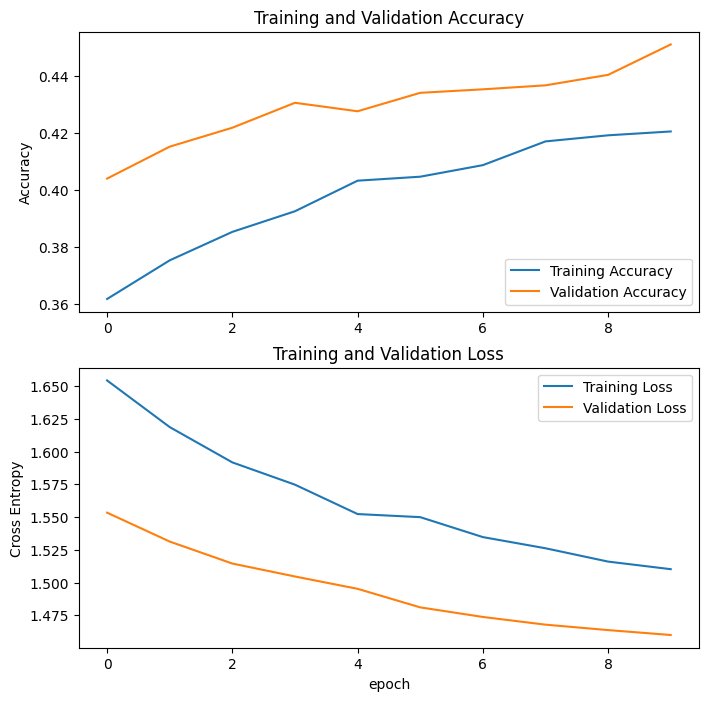

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [50]:
base_model.trainable = True

In [51]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [52]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         


 a)                                                              


 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         


 da)                                                             


 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   


 tional)                                                         


 global_average_pooling2d (  (None, 1280)              0         


 GlobalAveragePooling2D)                                         


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 1)                 1281      


Total params: 2259265 (8.62 MB)


Trainable params: 1862721 (7.11 MB)


Non-trainable params: 396544 (1.51 MB)


_________________________________________________________________


In [54]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [55]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
719/719 [==============================] - 65s 68ms/step - loss: 1.4547 - accuracy: 0.4441 - val_loss: 1.3496 - val_accuracy: 0.4956
Epoch 11/20
719/719 [==============================] - 57s 71ms/step - loss: 1.3668 - accuracy: 0.4818 - val_loss: 1.2821 - val_accuracy: 0.5192
Epoch 12/20
719/719 [==============================] - 64s 77ms/step - loss: 1.3137 - accuracy: 0.5034 - val_loss: 1.2705 - val_accuracy: 0.5201
Epoch 13/20
719/719 [==============================] - 58s 68ms/step - loss: 1.2772 - accuracy: 0.5110 - val_loss: 1.2237 - val_accuracy: 0.5391
Epoch 14/20
719/719 [==============================] - 58s 70ms/step - loss: 1.2435 - accuracy: 0.5262 - val_loss: 1.1881 - val_accuracy: 0.5525
Epoch 15/20
719/719 [==============================] - 63s 76ms/step - loss: 1.2134 - accuracy: 0.5387 - val_loss: 1.1816 - val_accuracy: 0.5594
Epoch 16/20
719/719 [==============================] - 61s 73ms/step - loss: 1.1838 - accuracy: 0.5512 - val_loss: 1.1521 - val_ac

14/63 [=====>........................] - ETA: 1s - loss: 0.1814 - accuracy: 0.9263

16/63 [======>.......................] - ETA: 1s - loss: 0.1797 - accuracy: 0.9258

18/63 [=======>......................] - ETA: 1s - loss: 0.1712 - accuracy: 0.9288

20/63 [========>.....................] - ETA: 1s - loss: 0.1717 - accuracy: 0.9266

22/63 [=========>....................] - ETA: 1s - loss: 0.1704 - accuracy: 0.9276

24/63 [==========>...................] - ETA: 1s - loss: 0.1656 - accuracy: 0.9310

26/63 [===========>..................] - ETA: 1s - loss: 0.1667 - accuracy: 0.9315

28/63 [============>.................] - ETA: 1s - loss: 0.1603 - accuracy: 0.9353

30/63 [=============>................] - ETA: 1s - loss: 0.1692 - accuracy: 0.9323

32/63 [==============>...............] - ETA: 1s - loss: 0.1726 - accuracy: 0.9316

34/63 [===============>..............] - ETA: 1s - loss: 0.1692 - accuracy: 0.9338

36/63 [================>.............] - ETA: 1s - loss: 0.1681 - accuracy: 0.9340

38/63 [=================>............] - ETA: 0s - loss: 0.1690 - accuracy: 0.9342

40/63 [==================>...........] - ETA: 0s - loss: 0.1654 - accuracy: 0.9359

42/63 [===================>..........] - ETA: 0s - loss: 0.1619 - accuracy: 0.9368

44/63 [===================>..........] - ETA: 0s - loss: 0.1627 - accuracy: 0.9368

46/63 [====================>.........] - ETA: 0s - loss: 0.1580 - accuracy: 0.9382

48/63 [=====================>........] - ETA: 0s - loss: 0.1573 - accuracy: 0.9375

50/63 [======================>.......] - ETA: 0s - loss: 0.1621 - accuracy: 0.9356

52/63 [=======================>......] - ETA: 0s - loss: 0.1594 - accuracy: 0.9369

54/63 [========================>.....] - ETA: 0s - loss: 0.1593 - accuracy: 0.9375

56/63 [=========================>....] - ETA: 0s - loss: 0.1606 - accuracy: 0.9381

58/63 [==========================>...] - ETA: 0s - loss: 0.1635 - accuracy: 0.9375

60/63 [===========================>..] - ETA: 0s - loss: 0.1622 - accuracy: 0.9380

62/63 [============================>.] - ETA: 0s - loss: 0.1616 - accuracy: 0.9380

63/63 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9385

63/63 [==============================] - 14s 62ms/step - loss: 0.1609 - accuracy: 0.9385 - val_loss: 0.0596 - val_accuracy: 0.9814


Epoch 11/20


 1/63 [..............................] - ETA: 4s - loss: 0.2132 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 2s - loss: 0.1786 - accuracy: 0.9375

 5/63 [=>............................] - ETA: 2s - loss: 0.1285 - accuracy: 0.9625

 7/63 [==>...........................] - ETA: 1s - loss: 0.1282 - accuracy: 0.9554

 9/63 [===>..........................] - ETA: 1s - loss: 0.1307 - accuracy: 0.9583

11/63 [====>.........................] - ETA: 1s - loss: 0.1331 - accuracy: 0.9489

13/63 [=====>........................] - ETA: 1s - loss: 0.1307 - accuracy: 0.9495

15/63 [======>.......................] - ETA: 1s - loss: 0.1403 - accuracy: 0.9458

17/63 [=======>......................] - ETA: 1s - loss: 0.1308 - accuracy: 0.9504

19/63 [========>.....................] - ETA: 1s - loss: 0.1286 - accuracy: 0.9490

21/63 [=========>....................] - ETA: 1s - loss: 0.1324 - accuracy: 0.9479

23/63 [=========>....................] - ETA: 1s - loss: 0.1313 - accuracy: 0.9484

25/63 [==========>...................] - ETA: 1s - loss: 0.1288 - accuracy: 0.9513

27/63 [===========>..................] - ETA: 1s - loss: 0.1223 - accuracy: 0.9537

29/63 [============>.................] - ETA: 1s - loss: 0.1275 - accuracy: 0.9515

31/63 [=============>................] - ETA: 1s - loss: 0.1254 - accuracy: 0.9516

33/63 [==============>...............] - ETA: 1s - loss: 0.1293 - accuracy: 0.9508

35/63 [===============>..............] - ETA: 0s - loss: 0.1289 - accuracy: 0.9500

37/63 [================>.............] - ETA: 0s - loss: 0.1263 - accuracy: 0.9510

39/63 [=================>............] - ETA: 0s - loss: 0.1232 - accuracy: 0.9527

41/63 [==================>...........] - ETA: 0s - loss: 0.1228 - accuracy: 0.9527

43/63 [===================>..........] - ETA: 0s - loss: 0.1218 - accuracy: 0.9520

45/63 [====================>.........] - ETA: 0s - loss: 0.1227 - accuracy: 0.9514

47/63 [=====================>........] - ETA: 0s - loss: 0.1217 - accuracy: 0.9521

49/63 [======================>.......] - ETA: 0s - loss: 0.1198 - accuracy: 0.9528

51/63 [=======================>......] - ETA: 0s - loss: 0.1205 - accuracy: 0.9528

53/63 [========================>.....] - ETA: 0s - loss: 0.1187 - accuracy: 0.9540

55/63 [=========================>....] - ETA: 0s - loss: 0.1173 - accuracy: 0.9545

57/63 [==========================>...] - ETA: 0s - loss: 0.1236 - accuracy: 0.9518

59/63 [===========================>..] - ETA: 0s - loss: 0.1221 - accuracy: 0.9529

61/63 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9518

63/63 [==============================] - ETA: 0s - loss: 0.1249 - accuracy: 0.9510

63/63 [==============================] - 3s 45ms/step - loss: 0.1249 - accuracy: 0.9510 - val_loss: 0.0508 - val_accuracy: 0.9876


Epoch 12/20


 1/63 [..............................] - ETA: 4s - loss: 0.0919 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.0598 - accuracy: 0.9896

 5/63 [=>............................] - ETA: 2s - loss: 0.0720 - accuracy: 0.9750

 7/63 [==>...........................] - ETA: 1s - loss: 0.0711 - accuracy: 0.9777

 9/63 [===>..........................] - ETA: 1s - loss: 0.0724 - accuracy: 0.9757

11/63 [====>.........................] - ETA: 1s - loss: 0.0689 - accuracy: 0.9773

13/63 [=====>........................] - ETA: 1s - loss: 0.0709 - accuracy: 0.9784

15/63 [======>.......................] - ETA: 1s - loss: 0.0698 - accuracy: 0.9771

17/63 [=======>......................] - ETA: 1s - loss: 0.0735 - accuracy: 0.9724

19/63 [========>.....................] - ETA: 1s - loss: 0.0771 - accuracy: 0.9688

21/63 [=========>....................] - ETA: 1s - loss: 0.0811 - accuracy: 0.9688

23/63 [=========>....................] - ETA: 1s - loss: 0.0846 - accuracy: 0.9647

25/63 [==========>...................] - ETA: 1s - loss: 0.0883 - accuracy: 0.9625

27/63 [===========>..................] - ETA: 1s - loss: 0.0889 - accuracy: 0.9630

29/63 [============>.................] - ETA: 1s - loss: 0.0900 - accuracy: 0.9644

31/63 [=============>................] - ETA: 1s - loss: 0.0865 - accuracy: 0.9657

33/63 [==============>...............] - ETA: 1s - loss: 0.0877 - accuracy: 0.9650

35/63 [===============>..............] - ETA: 0s - loss: 0.0865 - accuracy: 0.9652

37/63 [================>.............] - ETA: 0s - loss: 0.1031 - accuracy: 0.9595

39/63 [=================>............] - ETA: 0s - loss: 0.1020 - accuracy: 0.9599

41/63 [==================>...........] - ETA: 0s - loss: 0.1022 - accuracy: 0.9596

43/63 [===================>..........] - ETA: 0s - loss: 0.0992 - accuracy: 0.9615

45/63 [====================>.........] - ETA: 0s - loss: 0.0967 - accuracy: 0.9632

47/63 [=====================>........] - ETA: 0s - loss: 0.1000 - accuracy: 0.9621

49/63 [======================>.......] - ETA: 0s - loss: 0.1012 - accuracy: 0.9611

51/63 [=======================>......] - ETA: 0s - loss: 0.1029 - accuracy: 0.9589

53/63 [========================>.....] - ETA: 0s - loss: 0.1014 - accuracy: 0.9599

55/63 [=========================>....] - ETA: 0s - loss: 0.1026 - accuracy: 0.9591

57/63 [==========================>...] - ETA: 0s - loss: 0.1047 - accuracy: 0.9578

59/63 [===========================>..] - ETA: 0s - loss: 0.1050 - accuracy: 0.9582

61/63 [============================>.] - ETA: 0s - loss: 0.1058 - accuracy: 0.9580

63/63 [==============================] - ETA: 0s - loss: 0.1084 - accuracy: 0.9575

63/63 [==============================] - 3s 45ms/step - loss: 0.1084 - accuracy: 0.9575 - val_loss: 0.0497 - val_accuracy: 0.9864


Epoch 13/20


 1/63 [..............................] - ETA: 4s - loss: 0.0335 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0771 - accuracy: 0.9792

 5/63 [=>............................] - ETA: 2s - loss: 0.1395 - accuracy: 0.9500

 7/63 [==>...........................] - ETA: 1s - loss: 0.1168 - accuracy: 0.9598

 9/63 [===>..........................] - ETA: 1s - loss: 0.1194 - accuracy: 0.9583

11/63 [====>.........................] - ETA: 1s - loss: 0.1063 - accuracy: 0.9659

13/63 [=====>........................] - ETA: 1s - loss: 0.1055 - accuracy: 0.9639

15/63 [======>.......................] - ETA: 1s - loss: 0.1056 - accuracy: 0.9646

17/63 [=======>......................] - ETA: 1s - loss: 0.1027 - accuracy: 0.9669

19/63 [========>.....................] - ETA: 1s - loss: 0.1011 - accuracy: 0.9671

21/63 [=========>....................] - ETA: 1s - loss: 0.0992 - accuracy: 0.9673

23/63 [=========>....................] - ETA: 1s - loss: 0.0988 - accuracy: 0.9660

25/63 [==========>...................] - ETA: 1s - loss: 0.1002 - accuracy: 0.9650

27/63 [===========>..................] - ETA: 1s - loss: 0.0976 - accuracy: 0.9676

29/63 [============>.................] - ETA: 1s - loss: 0.0982 - accuracy: 0.9644

31/63 [=============>................] - ETA: 1s - loss: 0.0977 - accuracy: 0.9627

33/63 [==============>...............] - ETA: 1s - loss: 0.0959 - accuracy: 0.9631

35/63 [===============>..............] - ETA: 0s - loss: 0.0958 - accuracy: 0.9625

37/63 [================>.............] - ETA: 0s - loss: 0.0921 - accuracy: 0.9645

39/63 [=================>............] - ETA: 0s - loss: 0.0905 - accuracy: 0.9655

41/63 [==================>...........] - ETA: 0s - loss: 0.0899 - accuracy: 0.9657

43/63 [===================>..........] - ETA: 0s - loss: 0.0917 - accuracy: 0.9644

45/63 [====================>.........] - ETA: 0s - loss: 0.0900 - accuracy: 0.9653

47/63 [=====================>........] - ETA: 0s - loss: 0.0950 - accuracy: 0.9634

49/63 [======================>.......] - ETA: 0s - loss: 0.0946 - accuracy: 0.9624

51/63 [=======================>......] - ETA: 0s - loss: 0.0922 - accuracy: 0.9638

53/63 [========================>.....] - ETA: 0s - loss: 0.0943 - accuracy: 0.9634

55/63 [=========================>....] - ETA: 0s - loss: 0.0938 - accuracy: 0.9642

57/63 [==========================>...] - ETA: 0s - loss: 0.0918 - accuracy: 0.9649

59/63 [===========================>..] - ETA: 0s - loss: 0.0920 - accuracy: 0.9645

61/63 [============================>.] - ETA: 0s - loss: 0.0902 - accuracy: 0.9652

63/63 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.9640

63/63 [==============================] - 3s 45ms/step - loss: 0.0938 - accuracy: 0.9640 - val_loss: 0.0393 - val_accuracy: 0.9851


Epoch 14/20


 1/63 [..............................] - ETA: 4s - loss: 0.0528 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0513 - accuracy: 0.9896

 5/63 [=>............................] - ETA: 2s - loss: 0.0613 - accuracy: 0.9875

 7/63 [==>...........................] - ETA: 1s - loss: 0.0708 - accuracy: 0.9777

 9/63 [===>..........................] - ETA: 1s - loss: 0.1012 - accuracy: 0.9549

11/63 [====>.........................] - ETA: 1s - loss: 0.0985 - accuracy: 0.9574

13/63 [=====>........................] - ETA: 1s - loss: 0.0952 - accuracy: 0.9615

15/63 [======>.......................] - ETA: 1s - loss: 0.0990 - accuracy: 0.9542

17/63 [=======>......................] - ETA: 1s - loss: 0.0945 - accuracy: 0.9559

19/63 [========>.....................] - ETA: 1s - loss: 0.0890 - accuracy: 0.9572

21/63 [=========>....................] - ETA: 1s - loss: 0.0818 - accuracy: 0.9613

23/63 [=========>....................] - ETA: 1s - loss: 0.0843 - accuracy: 0.9620

25/63 [==========>...................] - ETA: 1s - loss: 0.0847 - accuracy: 0.9625

27/63 [===========>..................] - ETA: 1s - loss: 0.0816 - accuracy: 0.9653

29/63 [============>.................] - ETA: 1s - loss: 0.0821 - accuracy: 0.9644

31/63 [=============>................] - ETA: 1s - loss: 0.0852 - accuracy: 0.9637

33/63 [==============>...............] - ETA: 1s - loss: 0.0842 - accuracy: 0.9650

35/63 [===============>..............] - ETA: 0s - loss: 0.0847 - accuracy: 0.9643

37/63 [================>.............] - ETA: 0s - loss: 0.0827 - accuracy: 0.9654

39/63 [=================>............] - ETA: 0s - loss: 0.0814 - accuracy: 0.9655

41/63 [==================>...........] - ETA: 0s - loss: 0.0823 - accuracy: 0.9657

43/63 [===================>..........] - ETA: 0s - loss: 0.0809 - accuracy: 0.9658

45/63 [====================>.........] - ETA: 0s - loss: 0.0803 - accuracy: 0.9660

47/63 [=====================>........] - ETA: 0s - loss: 0.0780 - accuracy: 0.9668

49/63 [======================>.......] - ETA: 0s - loss: 0.0820 - accuracy: 0.9662

51/63 [=======================>......] - ETA: 0s - loss: 0.0801 - accuracy: 0.9669

53/63 [========================>.....] - ETA: 0s - loss: 0.0811 - accuracy: 0.9670

55/63 [=========================>....] - ETA: 0s - loss: 0.0805 - accuracy: 0.9665

57/63 [==========================>...] - ETA: 0s - loss: 0.0806 - accuracy: 0.9666

59/63 [===========================>..] - ETA: 0s - loss: 0.0799 - accuracy: 0.9666

61/63 [============================>.] - ETA: 0s - loss: 0.0797 - accuracy: 0.9662

63/63 [==============================] - ETA: 0s - loss: 0.0799 - accuracy: 0.9660

63/63 [==============================] - 3s 45ms/step - loss: 0.0799 - accuracy: 0.9660 - val_loss: 0.0410 - val_accuracy: 0.9851


Epoch 15/20


 1/63 [..............................] - ETA: 4s - loss: 0.0231 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0217 - accuracy: 0.9896

 5/63 [=>............................] - ETA: 2s - loss: 0.0622 - accuracy: 0.9812

 7/63 [==>...........................] - ETA: 1s - loss: 0.0650 - accuracy: 0.9777

 9/63 [===>..........................] - ETA: 1s - loss: 0.0653 - accuracy: 0.9757

11/63 [====>.........................] - ETA: 1s - loss: 0.0816 - accuracy: 0.9716

13/63 [=====>........................] - ETA: 1s - loss: 0.1010 - accuracy: 0.9639

15/63 [======>.......................] - ETA: 1s - loss: 0.1032 - accuracy: 0.9604

17/63 [=======>......................] - ETA: 1s - loss: 0.0969 - accuracy: 0.9614

19/63 [========>.....................] - ETA: 1s - loss: 0.0913 - accuracy: 0.9622

21/63 [=========>....................] - ETA: 1s - loss: 0.0895 - accuracy: 0.9628

23/63 [=========>....................] - ETA: 1s - loss: 0.0894 - accuracy: 0.9633

25/63 [==========>...................] - ETA: 1s - loss: 0.0844 - accuracy: 0.9663

27/63 [===========>..................] - ETA: 1s - loss: 0.0837 - accuracy: 0.9664

29/63 [============>.................] - ETA: 1s - loss: 0.0799 - accuracy: 0.9677

31/63 [=============>................] - ETA: 1s - loss: 0.0799 - accuracy: 0.9667

33/63 [==============>...............] - ETA: 1s - loss: 0.0787 - accuracy: 0.9669

35/63 [===============>..............] - ETA: 0s - loss: 0.0770 - accuracy: 0.9688

37/63 [================>.............] - ETA: 0s - loss: 0.0844 - accuracy: 0.9654

39/63 [=================>............] - ETA: 0s - loss: 0.0835 - accuracy: 0.9655

41/63 [==================>...........] - ETA: 0s - loss: 0.0812 - accuracy: 0.9665

43/63 [===================>..........] - ETA: 0s - loss: 0.0799 - accuracy: 0.9666

45/63 [====================>.........] - ETA: 0s - loss: 0.0791 - accuracy: 0.9674

47/63 [=====================>........] - ETA: 0s - loss: 0.0761 - accuracy: 0.9688

49/63 [======================>.......] - ETA: 0s - loss: 0.0783 - accuracy: 0.9675

51/63 [=======================>......] - ETA: 0s - loss: 0.0794 - accuracy: 0.9669

53/63 [========================>.....] - ETA: 0s - loss: 0.0797 - accuracy: 0.9664

55/63 [=========================>....] - ETA: 0s - loss: 0.0799 - accuracy: 0.9659

57/63 [==========================>...] - ETA: 0s - loss: 0.0796 - accuracy: 0.9660

59/63 [===========================>..] - ETA: 0s - loss: 0.0790 - accuracy: 0.9656

61/63 [============================>.] - ETA: 0s - loss: 0.0804 - accuracy: 0.9641

63/63 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9645

63/63 [==============================] - 3s 45ms/step - loss: 0.0800 - accuracy: 0.9645 - val_loss: 0.0375 - val_accuracy: 0.9876


Epoch 16/20


 1/63 [..............................] - ETA: 4s - loss: 0.1240 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 2s - loss: 0.1169 - accuracy: 0.9479

 5/63 [=>............................] - ETA: 2s - loss: 0.1034 - accuracy: 0.9500

 7/63 [==>...........................] - ETA: 1s - loss: 0.0962 - accuracy: 0.9554

 9/63 [===>..........................] - ETA: 1s - loss: 0.1088 - accuracy: 0.9514

11/63 [====>.........................] - ETA: 1s - loss: 0.0931 - accuracy: 0.9602

13/63 [=====>........................] - ETA: 1s - loss: 0.0836 - accuracy: 0.9639

15/63 [======>.......................] - ETA: 1s - loss: 0.0792 - accuracy: 0.9667

17/63 [=======>......................] - ETA: 1s - loss: 0.0752 - accuracy: 0.9669

19/63 [========>.....................] - ETA: 1s - loss: 0.0738 - accuracy: 0.9655

21/63 [=========>....................] - ETA: 1s - loss: 0.0711 - accuracy: 0.9658

23/63 [=========>....................] - ETA: 1s - loss: 0.0700 - accuracy: 0.9674

25/63 [==========>...................] - ETA: 1s - loss: 0.0712 - accuracy: 0.9675

27/63 [===========>..................] - ETA: 1s - loss: 0.0728 - accuracy: 0.9664

29/63 [============>.................] - ETA: 1s - loss: 0.0778 - accuracy: 0.9623

31/63 [=============>................] - ETA: 1s - loss: 0.0778 - accuracy: 0.9627

33/63 [==============>...............] - ETA: 1s - loss: 0.0773 - accuracy: 0.9631

35/63 [===============>..............] - ETA: 0s - loss: 0.0799 - accuracy: 0.9625

37/63 [================>.............] - ETA: 0s - loss: 0.0806 - accuracy: 0.9620

39/63 [=================>............] - ETA: 0s - loss: 0.0798 - accuracy: 0.9623

41/63 [==================>...........] - ETA: 0s - loss: 0.0788 - accuracy: 0.9627

43/63 [===================>..........] - ETA: 0s - loss: 0.0795 - accuracy: 0.9629

45/63 [====================>.........] - ETA: 0s - loss: 0.0796 - accuracy: 0.9625

47/63 [=====================>........] - ETA: 0s - loss: 0.0785 - accuracy: 0.9634

49/63 [======================>.......] - ETA: 0s - loss: 0.0788 - accuracy: 0.9630

51/63 [=======================>......] - ETA: 0s - loss: 0.0774 - accuracy: 0.9638

53/63 [========================>.....] - ETA: 0s - loss: 0.0749 - accuracy: 0.9652

55/63 [=========================>....] - ETA: 0s - loss: 0.0776 - accuracy: 0.9642

57/63 [==========================>...] - ETA: 0s - loss: 0.0796 - accuracy: 0.9633

59/63 [===========================>..] - ETA: 0s - loss: 0.0817 - accuracy: 0.9619

61/63 [============================>.] - ETA: 0s - loss: 0.0797 - accuracy: 0.9631

63/63 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9640

63/63 [==============================] - 3s 45ms/step - loss: 0.0783 - accuracy: 0.9640 - val_loss: 0.0456 - val_accuracy: 0.9802


Epoch 17/20


 1/63 [..............................] - ETA: 4s - loss: 0.0222 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0360 - accuracy: 0.9896

 5/63 [=>............................] - ETA: 2s - loss: 0.0623 - accuracy: 0.9875

 7/63 [==>...........................] - ETA: 1s - loss: 0.0542 - accuracy: 0.9866

 9/63 [===>..........................] - ETA: 1s - loss: 0.0588 - accuracy: 0.9826

11/63 [====>.........................] - ETA: 1s - loss: 0.0811 - accuracy: 0.9716

13/63 [=====>........................] - ETA: 1s - loss: 0.0750 - accuracy: 0.9736

15/63 [======>.......................] - ETA: 1s - loss: 0.0812 - accuracy: 0.9667

17/63 [=======>......................] - ETA: 1s - loss: 0.0807 - accuracy: 0.9669

19/63 [========>.....................] - ETA: 1s - loss: 0.0791 - accuracy: 0.9688

21/63 [=========>....................] - ETA: 1s - loss: 0.0761 - accuracy: 0.9717

23/63 [=========>....................] - ETA: 1s - loss: 0.0825 - accuracy: 0.9660

25/63 [==========>...................] - ETA: 1s - loss: 0.0774 - accuracy: 0.9675

27/63 [===========>..................] - ETA: 1s - loss: 0.0758 - accuracy: 0.9688

29/63 [============>.................] - ETA: 1s - loss: 0.0744 - accuracy: 0.9688

31/63 [=============>................] - ETA: 1s - loss: 0.0709 - accuracy: 0.9708

33/63 [==============>...............] - ETA: 1s - loss: 0.0731 - accuracy: 0.9706

35/63 [===============>..............] - ETA: 0s - loss: 0.0731 - accuracy: 0.9705

37/63 [================>.............] - ETA: 0s - loss: 0.0737 - accuracy: 0.9713

39/63 [=================>............] - ETA: 0s - loss: 0.0711 - accuracy: 0.9728

41/63 [==================>...........] - ETA: 0s - loss: 0.0699 - accuracy: 0.9726

43/63 [===================>..........] - ETA: 0s - loss: 0.0731 - accuracy: 0.9717

45/63 [====================>.........] - ETA: 0s - loss: 0.0730 - accuracy: 0.9715

47/63 [=====================>........] - ETA: 0s - loss: 0.0753 - accuracy: 0.9694

49/63 [======================>.......] - ETA: 0s - loss: 0.0752 - accuracy: 0.9688

51/63 [=======================>......] - ETA: 0s - loss: 0.0737 - accuracy: 0.9694

53/63 [========================>.....] - ETA: 0s - loss: 0.0721 - accuracy: 0.9705

55/63 [=========================>....] - ETA: 0s - loss: 0.0715 - accuracy: 0.9705

57/63 [==========================>...] - ETA: 0s - loss: 0.0697 - accuracy: 0.9715

59/63 [===========================>..] - ETA: 0s - loss: 0.0700 - accuracy: 0.9719

61/63 [============================>.] - ETA: 0s - loss: 0.0697 - accuracy: 0.9723

63/63 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9725

63/63 [==============================] - 3s 45ms/step - loss: 0.0687 - accuracy: 0.9725 - val_loss: 0.0493 - val_accuracy: 0.9827


Epoch 18/20


 1/63 [..............................] - ETA: 4s - loss: 0.0423 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0984 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 2s - loss: 0.0787 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 1s - loss: 0.0925 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 1s - loss: 0.0932 - accuracy: 0.9583

11/63 [====>.........................] - ETA: 1s - loss: 0.0985 - accuracy: 0.9574

13/63 [=====>........................] - ETA: 1s - loss: 0.0941 - accuracy: 0.9591

15/63 [======>.......................] - ETA: 1s - loss: 0.0835 - accuracy: 0.9646

17/63 [=======>......................] - ETA: 1s - loss: 0.0792 - accuracy: 0.9669

19/63 [========>.....................] - ETA: 1s - loss: 0.0746 - accuracy: 0.9688

21/63 [=========>....................] - ETA: 1s - loss: 0.0684 - accuracy: 0.9717

23/63 [=========>....................] - ETA: 1s - loss: 0.0678 - accuracy: 0.9728

25/63 [==========>...................] - ETA: 1s - loss: 0.0686 - accuracy: 0.9725

27/63 [===========>..................] - ETA: 1s - loss: 0.0657 - accuracy: 0.9734

29/63 [============>.................] - ETA: 1s - loss: 0.0653 - accuracy: 0.9731

31/63 [=============>................] - ETA: 1s - loss: 0.0620 - accuracy: 0.9748

33/63 [==============>...............] - ETA: 1s - loss: 0.0613 - accuracy: 0.9763

35/63 [===============>..............] - ETA: 0s - loss: 0.0614 - accuracy: 0.9768

37/63 [================>.............] - ETA: 0s - loss: 0.0588 - accuracy: 0.9780

39/63 [=================>............] - ETA: 0s - loss: 0.0579 - accuracy: 0.9784

41/63 [==================>...........] - ETA: 0s - loss: 0.0607 - accuracy: 0.9779

43/63 [===================>..........] - ETA: 0s - loss: 0.0611 - accuracy: 0.9767

45/63 [====================>.........] - ETA: 0s - loss: 0.0612 - accuracy: 0.9757

47/63 [=====================>........] - ETA: 0s - loss: 0.0610 - accuracy: 0.9754

49/63 [======================>.......] - ETA: 0s - loss: 0.0615 - accuracy: 0.9751

51/63 [=======================>......] - ETA: 0s - loss: 0.0630 - accuracy: 0.9743

53/63 [========================>.....] - ETA: 0s - loss: 0.0618 - accuracy: 0.9746

55/63 [=========================>....] - ETA: 0s - loss: 0.0628 - accuracy: 0.9739

57/63 [==========================>...] - ETA: 0s - loss: 0.0625 - accuracy: 0.9742

59/63 [===========================>..] - ETA: 0s - loss: 0.0623 - accuracy: 0.9740

61/63 [============================>.] - ETA: 0s - loss: 0.0612 - accuracy: 0.9749

63/63 [==============================] - ETA: 0s - loss: 0.0662 - accuracy: 0.9735

63/63 [==============================] - 3s 45ms/step - loss: 0.0662 - accuracy: 0.9735 - val_loss: 0.0415 - val_accuracy: 0.9851


Epoch 19/20


 1/63 [..............................] - ETA: 4s - loss: 0.0797 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 2s - loss: 0.0373 - accuracy: 0.9792

 5/63 [=>............................] - ETA: 2s - loss: 0.0751 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 1s - loss: 0.0837 - accuracy: 0.9643

 9/63 [===>..........................] - ETA: 1s - loss: 0.0707 - accuracy: 0.9722

11/63 [====>.........................] - ETA: 1s - loss: 0.0732 - accuracy: 0.9688

13/63 [=====>........................] - ETA: 1s - loss: 0.0745 - accuracy: 0.9663

15/63 [======>.......................] - ETA: 1s - loss: 0.0727 - accuracy: 0.9667

17/63 [=======>......................] - ETA: 1s - loss: 0.0663 - accuracy: 0.9706

19/63 [========>.....................] - ETA: 1s - loss: 0.0689 - accuracy: 0.9688

21/63 [=========>....................] - ETA: 1s - loss: 0.0663 - accuracy: 0.9702

23/63 [=========>....................] - ETA: 1s - loss: 0.0633 - accuracy: 0.9728

25/63 [==========>...................] - ETA: 1s - loss: 0.0623 - accuracy: 0.9737

27/63 [===========>..................] - ETA: 1s - loss: 0.0615 - accuracy: 0.9745

29/63 [============>.................] - ETA: 1s - loss: 0.0629 - accuracy: 0.9731

31/63 [=============>................] - ETA: 1s - loss: 0.0653 - accuracy: 0.9728

33/63 [==============>...............] - ETA: 1s - loss: 0.0735 - accuracy: 0.9706

35/63 [===============>..............] - ETA: 0s - loss: 0.0731 - accuracy: 0.9714

37/63 [================>.............] - ETA: 0s - loss: 0.0752 - accuracy: 0.9704

39/63 [=================>............] - ETA: 0s - loss: 0.0735 - accuracy: 0.9704

41/63 [==================>...........] - ETA: 0s - loss: 0.0707 - accuracy: 0.9718

43/63 [===================>..........] - ETA: 0s - loss: 0.0707 - accuracy: 0.9717

45/63 [====================>.........] - ETA: 0s - loss: 0.0708 - accuracy: 0.9708

47/63 [=====================>........] - ETA: 0s - loss: 0.0704 - accuracy: 0.9714

49/63 [======================>.......] - ETA: 0s - loss: 0.0708 - accuracy: 0.9713

51/63 [=======================>......] - ETA: 0s - loss: 0.0698 - accuracy: 0.9712

53/63 [========================>.....] - ETA: 0s - loss: 0.0686 - accuracy: 0.9711

55/63 [=========================>....] - ETA: 0s - loss: 0.0669 - accuracy: 0.9722

57/63 [==========================>...] - ETA: 0s - loss: 0.0675 - accuracy: 0.9715

59/63 [===========================>..] - ETA: 0s - loss: 0.0674 - accuracy: 0.9714

61/63 [============================>.] - ETA: 0s - loss: 0.0660 - accuracy: 0.9723

63/63 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.9720

63/63 [==============================] - 3s 45ms/step - loss: 0.0663 - accuracy: 0.9720 - val_loss: 0.0481 - val_accuracy: 0.9839


Epoch 20/20


 1/63 [..............................] - ETA: 4s - loss: 0.1514 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 2s - loss: 0.0863 - accuracy: 0.9479

 5/63 [=>............................] - ETA: 2s - loss: 0.0740 - accuracy: 0.9625

 7/63 [==>...........................] - ETA: 1s - loss: 0.0579 - accuracy: 0.9732

 9/63 [===>..........................] - ETA: 1s - loss: 0.0554 - accuracy: 0.9757

11/63 [====>.........................] - ETA: 1s - loss: 0.0625 - accuracy: 0.9716

13/63 [=====>........................] - ETA: 1s - loss: 0.0660 - accuracy: 0.9736

15/63 [======>.......................] - ETA: 1s - loss: 0.0673 - accuracy: 0.9750

17/63 [=======>......................] - ETA: 1s - loss: 0.0671 - accuracy: 0.9724

19/63 [========>.....................] - ETA: 1s - loss: 0.0640 - accuracy: 0.9737

21/63 [=========>....................] - ETA: 1s - loss: 0.0594 - accuracy: 0.9762

23/63 [=========>....................] - ETA: 1s - loss: 0.0606 - accuracy: 0.9755

25/63 [==========>...................] - ETA: 1s - loss: 0.0624 - accuracy: 0.9750

27/63 [===========>..................] - ETA: 1s - loss: 0.0612 - accuracy: 0.9757

29/63 [============>.................] - ETA: 1s - loss: 0.0599 - accuracy: 0.9763

31/63 [=============>................] - ETA: 1s - loss: 0.0600 - accuracy: 0.9758

33/63 [==============>...............] - ETA: 1s - loss: 0.0598 - accuracy: 0.9763

35/63 [===============>..............] - ETA: 0s - loss: 0.0621 - accuracy: 0.9768

37/63 [================>.............] - ETA: 0s - loss: 0.0591 - accuracy: 0.9780

39/63 [=================>............] - ETA: 0s - loss: 0.0619 - accuracy: 0.9768

41/63 [==================>...........] - ETA: 0s - loss: 0.0611 - accuracy: 0.9764

43/63 [===================>..........] - ETA: 0s - loss: 0.0615 - accuracy: 0.9753

45/63 [====================>.........] - ETA: 0s - loss: 0.0610 - accuracy: 0.9750

47/63 [=====================>........] - ETA: 0s - loss: 0.0609 - accuracy: 0.9747

49/63 [======================>.......] - ETA: 0s - loss: 0.0615 - accuracy: 0.9745

51/63 [=======================>......] - ETA: 0s - loss: 0.0598 - accuracy: 0.9755

53/63 [========================>.....] - ETA: 0s - loss: 0.0597 - accuracy: 0.9758

55/63 [=========================>....] - ETA: 0s - loss: 0.0590 - accuracy: 0.9756

57/63 [==========================>...] - ETA: 0s - loss: 0.0600 - accuracy: 0.9753

59/63 [===========================>..] - ETA: 0s - loss: 0.0600 - accuracy: 0.9756

61/63 [============================>.] - ETA: 0s - loss: 0.0603 - accuracy: 0.9759

63/63 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9760

63/63 [==============================] - 3s 46ms/step - loss: 0.0603 - accuracy: 0.9760 - val_loss: 0.0410 - val_accuracy: 0.9864


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [56]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

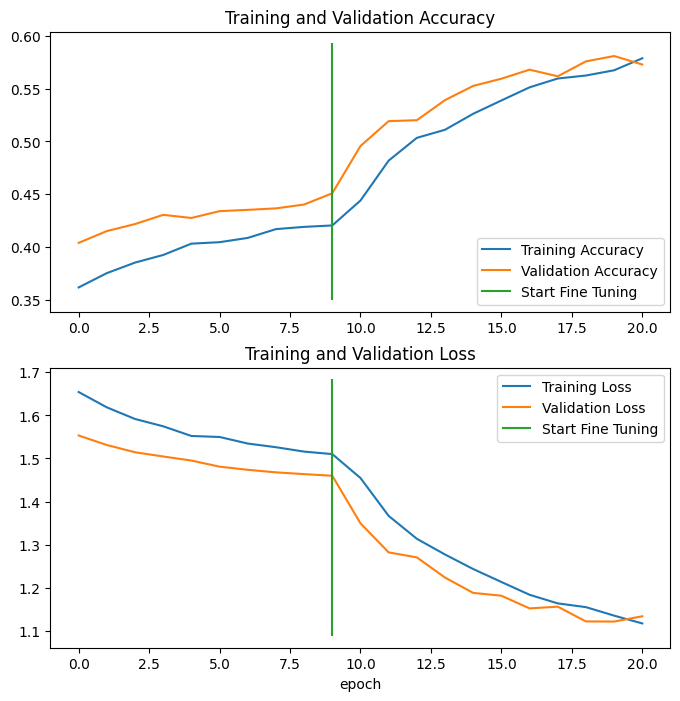

In [59]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [60]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

225/225 [==============================] - 12s 48ms/step - loss: 1.1266 - accuracy: 0.5740
Test accuracy : 0.5739760398864746


Test accuracy : 0.9791666865348816


Predictions:
 [0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0
 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0
 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0]
Labels:
 [6 4 5 1 2 2 5 3 6 4 2 4 4 3 1 0 4 5 3 5 6 5 5 5 6 0 2 4 2 3 4 3]


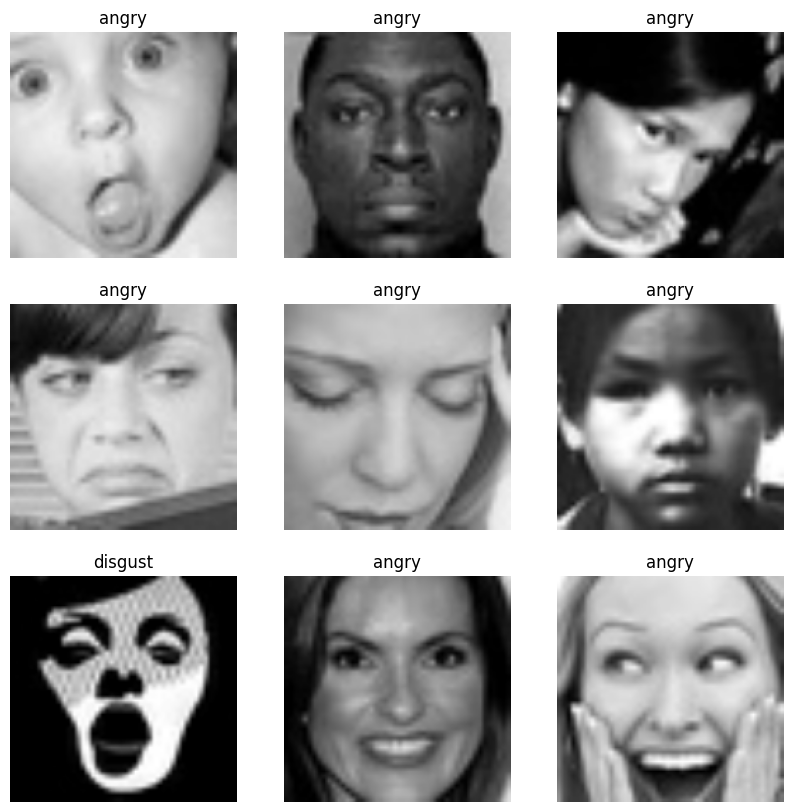

In [61]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).


In [63]:
model.save('mobilenet_v2', save_format='tf')

INFO:tensorflow:Assets written to: mobilenet_v2/assets


INFO:tensorflow:Assets written to: mobilenet_v2/assets


In [64]:
model.save('mobilenet_v2.keras')

In [65]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('mobilenet_v2') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

2023-08-21 20:35:07.876508: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-21 20:35:07.877534: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-21 20:35:07.895645: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: mobilenet_v2
2023-08-21 20:35:07.934136: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-08-21 20:35:07.934215: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: mobilenet_v2
2023-08-21 20:35:07.998388: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-08-21 20:35:08.017995: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-08-21 20:35:08.615612: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: mobilenet_v2
2023-08-21 20:35:08